# Ejercicio 4: Defina dos  redes convolucionales diferentes que sean capaces de clasificar la base MNIST. Utilice para entrenar ambas la base de entrenamiento aumentada (por 21=3x3x3) utilizando rotación, escala y traslación.

In [0]:
# librerias necesarias     
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import cv2

In [113]:
from tensorflow.examples.tutorials.mnist import input_data

# importo y guardo MNIST data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


## Exploración del dataset

In [114]:
# dimensiones de la data
print(f"Imagenes de Entrenamiento: {mnist.train.images.shape}")
print(f"Labels de Entrenamiento: {mnist.train.labels.shape}")

print(f"Imagenes de Testeo: {mnist.test.images.shape}")
print(f"Labels de Testeo: {mnist.test.labels.shape}")

Imagenes de Entrenamiento: (55000, 784)
Labels de Entrenamiento: (55000, 10)
Imagenes de Testeo: (10000, 784)
Labels de Testeo: (10000, 10)


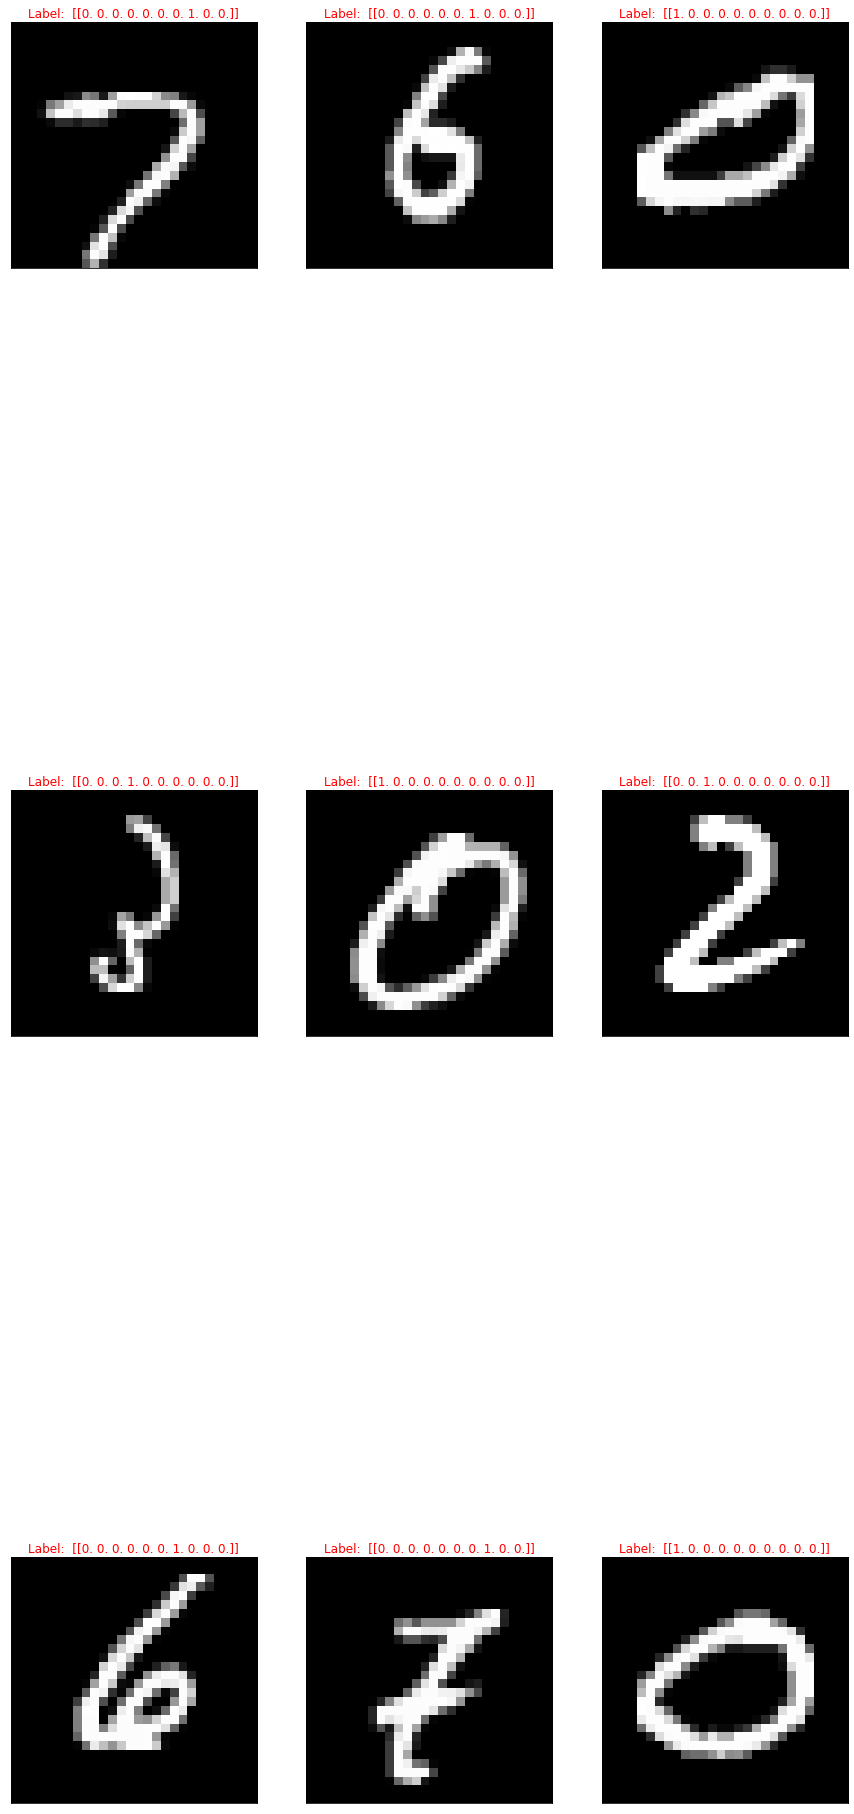

In [115]:
# visualizamos algunas imagenes
fig, ax = plt.subplots(3, 3, figsize=[15, 40])

random_image = np.random.randint(low=0, high=55000, size=1)

for j in range(3):
    for i in range(3):
        
       random_image = np.random.randint(low=0, high=55000, size=1)

       ax[i,j].imshow(mnist.train.images[random_image].reshape(28,28), 'gray')
       ax[i,j].set_xticks([])
       ax[i,j].set_yticks([])
       ax[i,j].set_title('Label:  ' + str(mnist.train.labels[random_image]), color='r')


plt.show()

# Datos de entrenamiento para el Modelo

In [0]:
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

In [0]:
X_train, X_test = X_train.reshape(55000, 28, 28), X_test.reshape(10000, 28, 28)

### Documentación de Keras: https://keras.io/

### Aumentación de datos por Rotación de Imágenes 

In [0]:
def rotacion(image, angle): 
    
    
    h, w = image.shape[0], image.shape[1]
    medio = (w/2, h/2)

    M = cv2.getRotationMatrix2D(medio, angle, 1.0)
    imagen_rotada = cv2.warpAffine(image, M, (w, h))
        
        
    return imagen_rotada

In [0]:
def escalar(image, angle,scale): 
    
    
    h, w = image.shape[0], image.shape[1]
    medio = (w/2, h/2)

    M = cv2.getRotationMatrix2D(medio, angle, scale)
    imagen_escalada = cv2.warpAffine(image, M, (w, h))
        
        
    return imagen_escalada

In [0]:
def dataAugmentation(images, labels):

  all_labels = []
  all_images = []

  for i in range(images.shape[0]):

    image, label = images[i], labels[i]

    all_images.append(image)
    all_labels.append(label)

    all_images.append(rotacion(image, 5))
    all_labels.append(label)    
    
    all_images.append(rotacion(image, -5))
    all_labels.append(label)

    all_images.append(escalar(image, 0, 1.75))
    all_labels.append(label)

  return np.asarray(all_images), np.asarray(all_labels)

In [121]:
print(X_train.shape[0])

55000


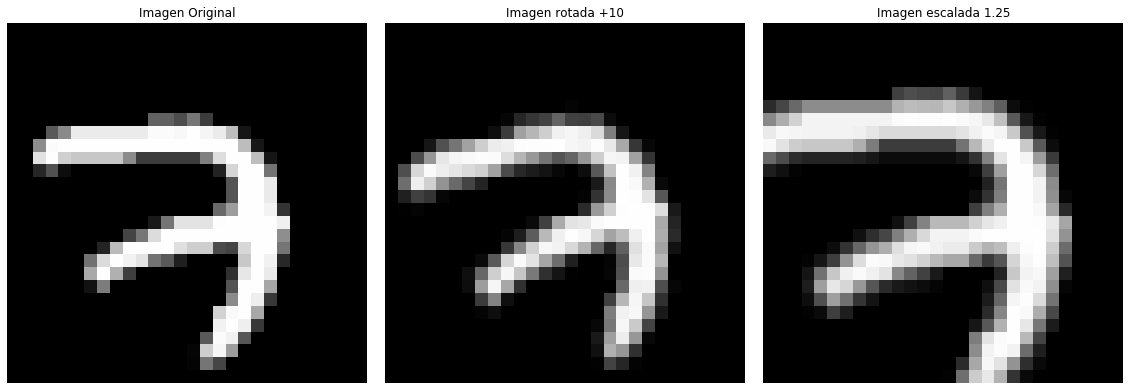

(28, 28)


In [122]:
fig, ax = plt.subplots(1, 3, figsize=(20,15))

ax[0].imshow(X_train[0], 'gray',vmin=0, vmax=1);
ax[0].axis('off')
ax[0].set_title('Imagen Original')

ax[1].imshow(rotacion(X_train[0], 10),'gray', vmin=0, vmax=1);
ax[1].axis('off')
ax[1].set_title('Imagen rotada +10')

ax[2].imshow(escalar(X_train[0], 0, 1.25),'gray', vmin=0, vmax=1);
ax[2].axis('off')
ax[2].set_title('Imagen escalada 1.25')

fig.subplots_adjust(wspace=0.05, top=0.8)
plt.show()
print(rotacion(X_train[0], 5).shape)

In [123]:
X_train, y_train = dataAugmentation(X_train, y_train)
print(X_train.shape,y_train.shape)

(220000, 28, 28) (220000, 10)


In [0]:
X_train, X_test = X_train.reshape(220000, 28, 28, 1), X_test.reshape(10000, 28, 28, 1)

### Uso de Drop out para evitar sobre-ajuste (overfitting) del modelo

In [0]:
### definiendo capa de entrada, capas ocultas, y capa de salida

entrada = Input(shape=(28,28,1))

conv1 = Conv2D(64, 5,activation="relu")(entrada)
bn1 = BatchNormalization()(conv1)
activation1 = Activation("relu")(bn1)
maxPool1 = MaxPooling2D(pool_size=(2, 2))(activation1)

conv2 = Conv2D(128, 5,activation="relu")(maxPool1)
bn2 = BatchNormalization()(conv2)
activation2 = Activation("relu")(bn2)
maxPool2 = MaxPooling2D(pool_size=(2, 2))(activation2)

flatten = Flatten()(maxPool2)

dense1 = Dense(256, activation="sigmoid")(flatten)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation="sigmoid")(dense1)
dense2 = Dropout(0.5)(dense2)

salida = Dense(10, activation="softmax")(dense2)


###

In [0]:
### definiendo entrada y salida del modelo

model = Model(inputs=entrada, outputs=salida)


In [0]:
### definiendo optimizador y funcion de costo

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
## para guardar el modelo
filepath = "prueba1.h5"
model_checkpoint = ModelCheckpoint(filepath, monitor='loss',verbose=1, save_best_only=True)

In [129]:
history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=3, validation_data=(X_test, y_test), callbacks=[model_checkpoint])

Train on 220000 samples, validate on 10000 samples
Epoch 1/3
220000/220000 [==============================] - 967s 4ms/step - loss: 0.1502 - acc: 0.9637 - val_loss: 0.0252 - val_acc: 0.9921

Epoch 00001: loss improved from inf to 0.15019, saving model to prueba1.h5
Epoch 2/3
220000/220000 [==============================] - 980s 4ms/step - loss: 0.0654 - acc: 0.9832 - val_loss: 0.0268 - val_acc: 0.9922

Epoch 00002: loss improved from 0.15019 to 0.06540, saving model to prueba1.h5
Epoch 3/3
220000/220000 [==============================] - 977s 4ms/step - loss: 0.0526 - acc: 0.9864 - val_loss: 0.0242 - val_acc: 0.9933

Epoch 00003: loss improved from 0.06540 to 0.05263, saving model to prueba1.h5


In [130]:
print("Accuracy, train:")
print(model.evaluate(X_train, y_train))

print("Accuracy, test:")
print(model.evaluate(X_test, y_test))

Accuracy, train:
220000/220000 [==============================] - 265s 1ms/step
[0.0237068664917848, 0.9926545454545455]
Accuracy, test:
10000/10000 [==============================] - 12s 1ms/step
[0.024181417207946653, 0.9933]


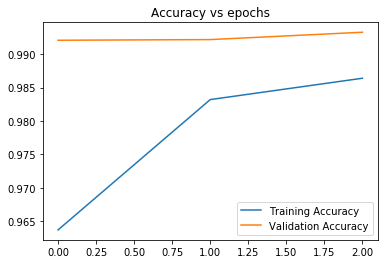

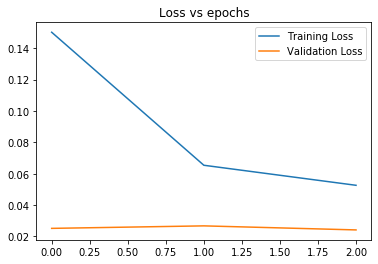

In [131]:
## visuzalimos curvas de entrenamiento

plt.figure()
plt.title("Accuracy vs epochs")
plt.plot( history.history['acc'] )
plt.plot( history.history['val_acc'] )
plt.legend(['Training Accuracy', 'Validation Accuracy'])


plt.figure()
plt.title("Loss vs epochs")
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.legend(['Training Loss', 'Validation Loss'])

## Usemos este modelo para hacer predicciones

In [0]:
## predicciones de las imagenes de testeo

predicciones = model.predict(X_test)

##

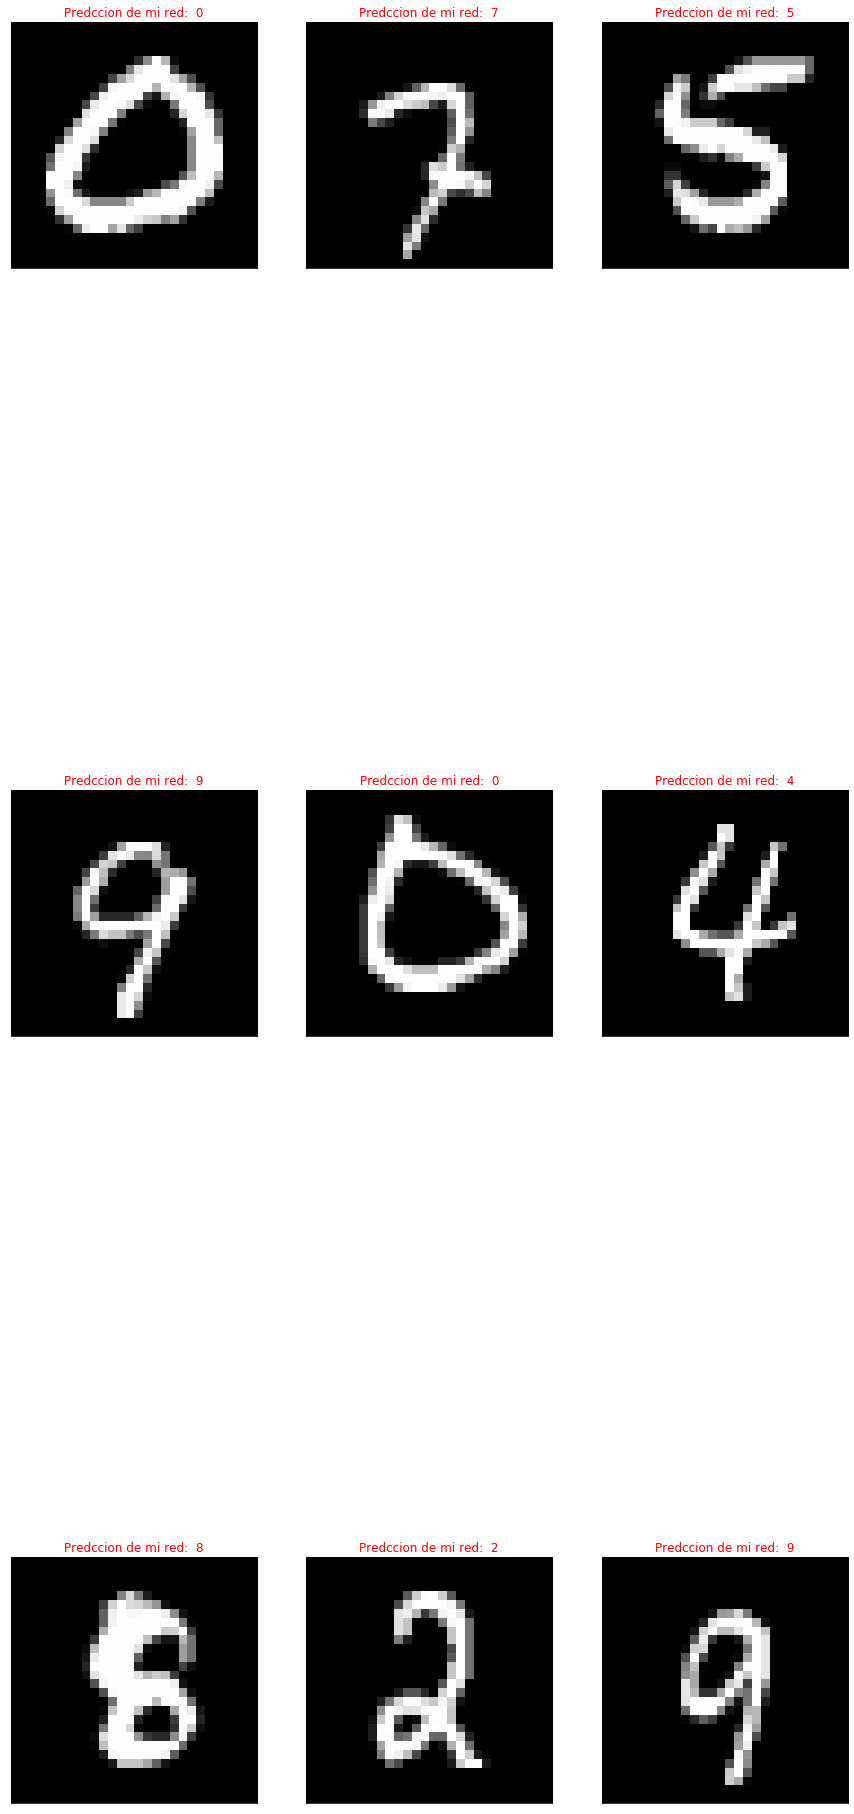

In [133]:
fig, ax = plt.subplots(3, 3, figsize=[15, 40])


for j in range(3):
    for i in range(3):
        
       random_image = np.random.randint(low=0, high=1000, size=1)

       ax[i,j].imshow(mnist.test.images[random_image].reshape(28,28), 'gray')
       ax[i,j].set_xticks([])
       ax[i,j].set_yticks([])
       ax[i,j].set_title('Predccion de mi red:  ' + str(np.argmax(predicciones[random_image])), color='r')

plt.show()